In [1]:
import numpy as np
import pandas as pd
import random as rand
import sklearn.preprocessing
from scipy.stats import norm
from sys import maxsize
from scipy.stats import multivariate_normal as mvn
from sklearn.datasets.samples_generator import make_blobs
import matplotlib.pyplot as plt
plt.ion()

Basic implementation of Expectation Maximization algorithm for gaussian distributions.

(300, 2)


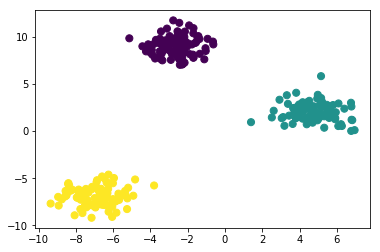

In [2]:
n_components = 3
X, truth = make_blobs(n_samples=300, centers=n_components, random_state=42)
/print X.shape
plt.scatter(X[:, 0], X[:, 1], s=50, c = truth);

Define input parameters and initial values for the parameters describing the chosen distribution.   
In the case of normal distribution, we define the mean and the covariace for each input feature (in our 2D case -> 2 input features)

Consider the priors as the equal probability of being part of one of the n_components clusters

In [3]:
def get_input_parameters(X, distribution_type, n_components):
    params = {}
    random_state = np.random.RandomState(0)
    n_samples, n_features = X.shape
    if distribution_type == "normal":
        params["distribution"] = "normal"
        
        params["convergence_delta"] = 1e-4
        params["max_epochs"] = 500
        
        params["priors"] = np.ones(n_components)/n_components
        # Choose the means as a random element of the input dataset, one for each cluster
        random_index_for_each_feature = random_state.choice(np.arange(n_samples), n_components)
        params["means"] = X[random_index_for_each_feature]
        params["covariances"] = np.empty((n_components, n_features, n_features))
        for k in range(n_components):
            params["covariances"][k] = np.eye(n_features)
            
    return params

In [4]:
def getPDF(X, params):
    """
    Probability density function of the input distribution. This is used in the exploration step in order to
    calculate for each observation the probability of being observed as part of cluster k.
    """
    if params['distribution'] == "normal":
        k = params['current_cluster']
        return mvn(params["means"][k], params["covariances"][k]).pdf(X)

In [5]:
def e_step(X, n_components, params):
    """
    Exploration phase: assigns to each observation the probability it was origindated from cluster k
    """
    n_samples, n_features = X.shape
    K = np.empty((n_samples, n_components))
    for k in range(n_components):
        params['current_cluster'] = k
        K[:, k]= params['priors'][k] * getPDF(X, params)
    # normalize matrix by rows before return
    K = sklearn.preprocessing.normalize(K, norm = 'l1', axis= 1)
    return K

In [6]:
def m_step(K, X, params):
    """
    Maximisation step: updates the parameters based on the current clustering
    result K
    """
    cluster_weights = K.sum(axis=0)
    K = K/cluster_weights
    params['priors'] =  sklearn.preprocessing.normalize(cluster_weights.reshape(-1, 1), norm = 'l1', axis = 0)
    if params['distribution'] == "normal":
        params['means'] = K.T.dot(X)
        for k in range(n_components):
            Xm = X - params['means'][k]
            params["covariances"][k] = (K[:, k, np.newaxis] * Xm).T.dot(Xm)
    return params

def convergence(K, K_prev, delta):
    """
    Check if the algorithm converged by estimating the difference between
    2 consecutive solutions. If the matrix norm is smaller than a given delta,
    we take this as a proof of convergence
    """
    if K_prev == None:
        return False
    return np.linalg.norm(K - K_prev) < delta

In [7]:
def mixture_clustering(X, distribution_type, n_components):
    # 1. Initialize distribution specific input parameters
    params = get_input_parameters(X, "normal", n_components)
    K_prev = None
    for i in range(params["max_epochs"]):
        # 2. Exploration phase calculates the cluster probability matrix K
        K = e_step(X, n_components, params)
        # Early stop of the optimisation if convergence
        if convergence(K, K_prev, params["convergence_delta"]):
            print(f"Early convergence epoch {i}")
            return np.argmax(K, axis = 1)
        # 3. Maximization step: update parameters with maximum a-posteriori estimates
        params = m_step(K, X, params)
    return np.argmax(K, axis = 1)

In [8]:
pred = mixture_clustering(X, "normal", n_components)

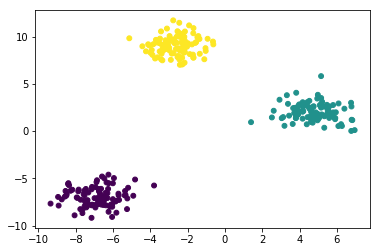

In [9]:
plt.scatter(X[:, 0], X[:, 1], 24, c=pred)

Verify cluster quality with adjusted rand index:

In [10]:
from sklearn.metrics.cluster import adjusted_rand_score
adjusted_rand_score(truth, pred)

1.0